In [17]:
import xarray as xr
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import torch
import torch.nn as nn
from torch.utils.data import DataLoader, TensorDataset
from torch.optim import Adam
import pickle

In [18]:
place = 'D'
#取数据
path1 = "D:\BaiduNetdiskDownload\data\donghai\\2011-2014.nc"
path2 = "D:\BaiduNetdiskDownload\data\donghai\\2015-2018.nc"
path3 = "D:\BaiduNetdiskDownload\data\donghai\\2019-2020.nc"
dataset1 = xr.open_dataset(path1)
dataset2 = xr.open_dataset(path2)
dataset3 = xr.open_dataset(path3)
dataset = xr.merge([dataset1,dataset2,dataset3])
# 目标D经纬度坐标
target_longitude = 124.00
target_latitude = 31.00
# 固定经度和纬度并获取其余信息
subset_data = dataset.sel(longitude=target_longitude, latitude=target_latitude, method='nearest')

In [19]:
#取数据
time = subset_data.variables['time'][:].data
u10 = subset_data.variables['u10'][:].data
v10 = subset_data.variables['v10'][:].data
swh = subset_data.variables['swh'][:].data
print(swh[0])
# 创建DataFrame来组织数据
data = pd.DataFrame({'time': time, 'u10': u10, 'v10': v10, 'swh': swh})

4.016243


In [20]:
hours = 24
#创建数据集
X = data[['u10', 'v10', 'swh']].values
y = data['swh'].values
y = np.roll(y,shift=-1*hours)
# 划分数据集为训练集和测试集
split_point = int(0.8 * len(X))
X_train = X[:split_point]
X_test = X[split_point:]
y_train = y[:split_point]
y_test = y[split_point:]
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print('number of train dataset:' , len(X_train))
print('number of test dataset:' , len(X_test))

number of train dataset: 70137
number of test dataset: 17535


In [21]:
# 标准化特征
scaler = MinMaxScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

In [22]:
# 将数据转换为PyTorch张量
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

In [23]:
# 创建PyTorch数据集和数据加载器
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

In [24]:
# 定义RNN模型
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 定义GRU模型
class GRUModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRUModel, self).__init__()
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.gru(x)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out
    
# 定义LSTM模型
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
    
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 取最后一个时间步的输出
        return out

In [25]:
# 创建模型实例
input_size = 3  # 输入特征数量（u10和v10）
hidden_size = 50
rnn_model = RNNModel(input_size, hidden_size)
gru_model = GRUModel(input_size, hidden_size)
lstm_model = LSTMModel(input_size, hidden_size)

In [26]:
# 定义损失函数和优化器
learning_rate = 0.001
criterion = nn.MSELoss()
rnn_optimizer = Adam(rnn_model.parameters(), lr=learning_rate)
gru_optimizer = Adam(gru_model.parameters(), lr=learning_rate)
lstm_optimizer = Adam(lstm_model.parameters(), lr=learning_rate)

In [27]:
# 训练模型
num_epochs = 10
print('RNN training...')
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        rnn_optimizer.zero_grad()
        outputs = rnn_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        rnn_optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 训练模型
print('GRU training...')
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        gru_optimizer.zero_grad()
        outputs = gru_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        gru_optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')
# 训练模型
print('LSTM training...')
for epoch in range(num_epochs):
    for inputs, labels in train_loader:
        lstm_optimizer.zero_grad()
        outputs = lstm_model(inputs.unsqueeze(1))
        loss = criterion(outputs, labels.unsqueeze(1))
        loss.backward()
        lstm_optimizer.step()
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

RNN training...
Epoch [1/10], Loss: 1.0905
Epoch [2/10], Loss: 0.1381
Epoch [3/10], Loss: 0.6298
Epoch [4/10], Loss: 0.5169
Epoch [5/10], Loss: 0.8293
Epoch [6/10], Loss: 0.4023
Epoch [7/10], Loss: 0.4956
Epoch [8/10], Loss: 0.7448
Epoch [9/10], Loss: 0.5308
Epoch [10/10], Loss: 0.3112
GRU training...
Epoch [1/10], Loss: 0.3256
Epoch [2/10], Loss: 3.7652
Epoch [3/10], Loss: 0.6821
Epoch [4/10], Loss: 0.2333
Epoch [5/10], Loss: 0.6072
Epoch [6/10], Loss: 0.3892
Epoch [7/10], Loss: 0.3901
Epoch [8/10], Loss: 0.3809
Epoch [9/10], Loss: 1.1112
Epoch [10/10], Loss: 0.6182
LSTM training...
Epoch [1/10], Loss: 0.6900
Epoch [2/10], Loss: 0.9362
Epoch [3/10], Loss: 0.2866
Epoch [4/10], Loss: 0.5000
Epoch [5/10], Loss: 0.3183
Epoch [6/10], Loss: 0.5141
Epoch [7/10], Loss: 0.4382
Epoch [8/10], Loss: 0.2743
Epoch [9/10], Loss: 0.5535
Epoch [10/10], Loss: 0.2091


In [28]:
# 测试模型
rnn_model.eval()
with torch.no_grad():
    y_pred_tensor_rnn = rnn_model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(y_pred_tensor_rnn, y_test_tensor.unsqueeze(1))

print(f'Test Loss: {test_loss.item():.4f}')

gru_model.eval()
with torch.no_grad():
    y_pred_tensor_gru = gru_model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(y_pred_tensor_gru, y_test_tensor.unsqueeze(1))

print(f'Test Loss: {test_loss.item():.4f}')

lstm_model.eval()
with torch.no_grad():
    y_pred_tensor_lstm = lstm_model(X_test_tensor.unsqueeze(1))
    test_loss = criterion(y_pred_tensor_lstm, y_test_tensor.unsqueeze(1))

print(f'Test Loss: {test_loss.item():.4f}')

Test Loss: 0.5268
Test Loss: 0.4990
Test Loss: 0.4978


In [29]:
# 将PyTorch张量转换回NumPy数组
y_pred_rnn = y_pred_tensor_rnn.numpy()
y_pred_gru = y_pred_tensor_gru.numpy()
y_pred_lstm = y_pred_tensor_lstm.numpy()
y_test = y_test_tensor.numpy()


In [30]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse_rnn = sqrt(mean_squared_error(y_test, y_pred_rnn))
rmse_gru = sqrt(mean_squared_error(y_test, y_pred_gru))
rmse_lstm = sqrt(mean_squared_error(y_test, y_pred_lstm))
print("RNN_RMSE:", rmse_rnn)
print("GRU_RMSE:", rmse_gru)
print("LSTM_RMSE:", rmse_lstm)

from scipy.stats import pearsonr
r_rnn, _ = pearsonr(y_test, y_pred_rnn)
r_gru, _ = pearsonr(y_test, y_pred_gru)
r_lstm, _ = pearsonr(y_test, y_pred_lstm)
print("RNN Correlation coefficient (R):", r_rnn)
print("RNN Correlation coefficient (R):", r_gru)
print("RNN Correlation coefficient (R):", r_lstm)

with open(place + '_params.txt', 'a') as file:
    # 使用 write() 方法写入文本内容
    file.write(str(hours)+'hours params:\n')
    file.write('RMES:\n')
    file.write('RNN:'+str(rmse_rnn)+'\n')
    file.write('GRU:'+str(rmse_gru)+'\n')
    file.write('LSTM:'+str(rmse_lstm)+'\n')
    file.write('R:\n')
    file.write('RNN:'+str(r_rnn)+'\n')
    file.write('GRU:'+str(r_gru)+'\n')
    file.write('LSTM:'+str(r_lstm)+'\n')
    file.write('\n')
    
# # 保存参数字典到文件
# training_params = {
#     'learning_rate': learning_rate,
#     'batch_size': batch_size,
#     'epochs': num_epochs,
# }

# validation_metrics = {
#     'RMSE_RNN': rmse_rnn,
#     'RMSE_GRU': rmse_gru,
#     'RMSE_LSTM': rmse_lstm,
#     'R_RNN': r_rnn,
#     'R_GRU': r_gru,
#     'R_LSTM': r_lstm
# }

# params_filename = str(hours) + 'hours_d_params.pkl'

# with open(params_filename, 'wb') as params_file:
#     pickle.dump({'training_params': training_params, 'validation_metrics': validation_metrics}, params_file)

# with open(params_filename, 'rb') as params_file:
#     loaded_params = pickle.load(params_file)

# loaded_training_params = loaded_params['training_params']
# loaded_validation_metrics = loaded_params['validation_metrics']

# print("加载的训练参数:", loaded_training_params)
# print("加载的验证指标:", loaded_validation_metrics)

RNN_RMSE: 0.7257866357248328
GRU_RMSE: 0.7064297050795936
LSTM_RMSE: 0.7055457089038244
RNN Correlation coefficient (R): [0.6026420766881521]
RNN Correlation coefficient (R): [0.6308364855137415]
RNN Correlation coefficient (R): [0.6298486344748307]


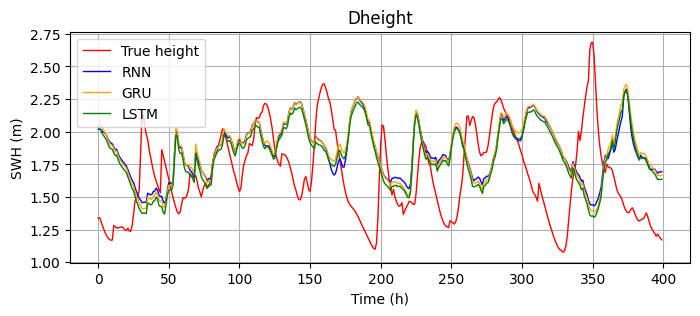

In [31]:
import matplotlib.pyplot as plt

time = np.arange(0, 400, 1)

#print(y_test[:400])

plt.figure(figsize=(8, 3))
plt.plot(time, y_test[800:1200], linestyle='-', linewidth=1.0,label='True height', color='red')
plt.plot(time, y_pred_rnn[800:1200], linestyle='-', linewidth=1.0, label='RNN', color='blue')
plt.plot(time, y_pred_gru[800:1200], linestyle='-', linewidth=1.0, label = 'GRU', color='orange')
plt.plot(time, y_pred_lstm[800:1200], linestyle='-', linewidth=1.0, label = 'LSTM', color='green')

plt.xlabel('Time (h)')
plt.ylabel('SWH (m)')
plt.title(place+'height')
plt.grid(True)
plt.legend()
plt.savefig(str(hours)+'_hours_'+ place +'_predict.png', dpi=300, bbox_inches='tight')
plt.show()